Goal:
classify a task for a given student as (1) too easy, (2) just right, or (3) too difficult.

Data:
- Robotanist, order and times of solved tasks
- proxy for difficulty levels:
- too easy = less than 1 minute
- too difficult = more than 10 minutes

Ideally, the same methods should be usable in scenario where we have explicit user information (qualitative data) about perceived difficulty (obtained via the flow-level question).

Usage:
- soft recommendation via color each task (too easy, just right, too difficult)
- soft recommendation via coarse time predictions (1m, 10m, >20m)
- set challenge level (1m or 10m)
- hard recommendation: hide/lock too easy/difficult tasks

In [282]:
%matplotlib inline
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Data

In [3]:
ordering = pd.read_csv('../data/robotanik/user_time_ordering.csv', index_col='Login')
# Make task IDs integers (from string labels).
ordering.columns = map(int, ordering.columns)
ordering.head()

,635,636,637,638,639,640,641,642,643,644,...,1402,1403,1404,1405,1406,1407,1704,1705,1706,1707
Login,,,,,,,,,,,,,,,,,,,,,
U1,1.0,2.0,13.0,5.0,NaN,9.0,NaN,NaN,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U2,1.0,2.0,4.0,3.0,5.0,6.0,9.0,10.0,8.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,58.0,59.0,60.0,61.0
U4,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U5,1.0,2.0,3.0,4.0,16.0,5.0,15.0,NaN,11.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U6,1.0,2.0,3.0,7.0,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
times = pd.read_csv('../data/robotanik/user_time.csv', index_col='Login')
# Make task IDs integers (from string labels).
times.columns = map(int, times.columns)
# Infere "true labels" (too difficult case)
TOO_DIFFICULT_THRESHOLD_MINUTES = 10
labels = times > 60 * TOO_DIFFICULT_THRESHOLD_MINUTES
#labels.head()
# We will work with log times; TODO: explain why
times = times.applymap(np.log)
times.head()

,635,636,637,638,639,640,641,642,643,644,...,1402,1403,1404,1405,1406,1407,1704,1705,1706,1707
Login,,,,,,,,,,,,,,,,,,,,,
U1,3.218876,2.564949,2.639057,3.637586,NaN,6.129050,NaN,NaN,NaN,4.882802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U2,2.302585,1.609438,3.891820,2.944439,4.521789,3.135494,4.043051,3.688879,3.737670,5.351858,...,NaN,NaN,NaN,NaN,NaN,NaN,5.220356,4.727388,3.583519,4.290459
U4,3.258097,1.791759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U5,3.951244,3.663562,3.218876,2.944439,5.897154,3.218876,4.595120,NaN,4.025352,3.828641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U6,4.219508,2.995732,3.465736,2.890372,NaN,3.737670,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


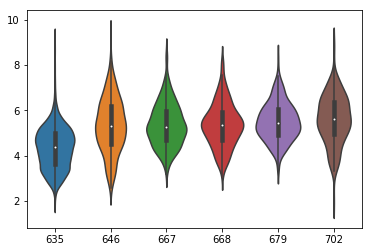

In [67]:
# distribution of log-times
sns.violinplot(data=times[[635, 646, 667, 668, 679, 702]])

The dataset contains about 10K of users and 80 tasks.

In [68]:
times.shape

(10605, 78)

# Features

Inital experiment - start with 2 features:
1. how many tasks has the student already solved (student_solved_percentage)
2. how many students have solved the task (task_solved_percentage)

Result: due to self-selection bias, student_solved_percentage correlated positively with too difficult task

New experiment:
1. average solving time of the task (all times are log-scaled)
2. average student delta from averge task time



Feature ideas:
- student-related (skill):
    - number of solved tasks
    - number of solved tasks in easy/flow/difficult mode
    - the most difficult solved task [in easy/flow/difficult mode]
    - which tasks solved [in which mode] / log-times / quartiles
- task-related (difficulty)
    - how many students have solved the task (percentage)
    - mean/median order
    - median log-time
    - percentage of easy/flow/difficult attempts
- content based

In [188]:
# create a dataframe of events (student-task interactions)
#task_count = times.shape[1]
data = []
for user_id in ordering.index:
    order = ordering.loc[user_id].dropna().sort_values()
    for task_id, student_order in order.items():
        event = OrderedDict(
            student_id=int(user_id[2:]),
            student_order=int(student_order),
            #student_solved_percentage=(student_order-1)/task_count,
            #student_avg_time_delta=2,
            task_id=int(task_id),
            time=times.loc[user_id, task_id],
            label=labels.loc[user_id, task_id])
        data.append(event)


events = pd.DataFrame(data)
print(events.shape)
events.head()

(121258, 5)


,student_id,student_order,task_id,time,label
0,1,1,635,3.218876,False
1,1,2,636,2.564949,False
2,1,3,656,4.595120,False
3,1,4,698,3.850148,False
4,1,5,638,3.637586,False


In [193]:
# train-test split (todo: cross validation)
# user-stratified
events_train = events[events.student_id < 15000]
events_test = events[events.student_id >= 15000]
print(len(events_train), len(events_test))

82219 39039


In [190]:
# compute task features on training-set
def compute_task_features(events_train):
    tasks = events_train.groupby('task_id')
    n_students = events_train.student_id.nunique()
    task_features = pd.DataFrame(OrderedDict(
      task_time_avg=tasks.time.mean(),
      task_time_median=tasks.time.median(),
      task_solved_percentage=tasks.time.count() / n_students
    ))
    return task_features

task_features = compute_task_features(events_train)
task_features.head()

,task_time_avg,task_time_median,task_solved_percentage
task_id,,,
635,4.333675,4.369448,0.881162
636,3.172100,3.044522,0.839055
637,4.418630,4.290459,0.602259
638,4.246620,4.276666,0.687940
639,5.153593,5.056246,0.128961


In [247]:
e = events_train.head(16)
e = join_task_features(e)
e['timedelta'] = (e.task_time_avg - e.time)
d = e.groupby('student_id').timedelta.expanding().mean()
d = d.groupby('student_id').shift().fillna(0)
e['avg'] = d.values
e

,student_id,student_order,task_id,time,label,task_time_avg,task_time_median,task_solved_percentage,timedelta,avg
0,1,1,635,3.218876,False,4.333675,4.369448,0.881162,1.114799,0.000000
1,1,2,636,2.564949,False,3.172100,3.044522,0.839055,0.607151,1.114799
2,1,3,656,4.595120,False,4.512972,4.442651,0.476819,-0.082147,0.860975
3,1,4,698,3.850148,False,4.515352,4.406719,0.470217,0.665204,0.546601
4,1,5,638,3.637586,False,4.246620,4.276666,0.687940,0.609034,0.576252
5,1,6,1124,2.639057,False,3.165334,2.995732,0.768192,0.526277,0.582808
6,1,7,1120,4.174387,False,4.251898,4.135135,0.621479,0.077510,0.573386
7,1,8,1119,5.308268,False,3.573933,3.465736,0.764525,-1.734334,0.502547
8,1,9,640,6.129050,False,4.417812,4.369448,0.634243,-1.711238,0.222937
9,1,10,644,4.882802,False,5.155558,5.206746,0.163439,0.272756,0.008029


In [252]:
def join_task_features(events):
    events = pd.merge(events, task_features, left_on='task_id', right_index=True)
    events.sort_values(by=['student_id', 'student_order'], inplace=True)
    return events

def add_derived_features(events):
    """Extend each event with computed features.
    """
    events = join_task_features(events)
    # todo: derive student features
    # features for students are derived from past attempts only
    events['timedelta'] = (events.task_time_avg - events.time)
    students = events.groupby('student_id')
    delta_avg = (
        events
        .groupby('student_id')
        .timedelta
        .expanding()
        .mean()
        .groupby('student_id')
        .shift().fillna(0)
    )
    events['student_timedelta_avg'] = delta_avg.values
    events.pop('timedelta')
    return events

events_train = add_derived_features(events_train)
events_test = add_derived_features(events_test)
events_train.head()
#add_derived_features(events_train.head(40)).head(16)

,student_id,student_order,task_id,time,label,task_time_avg,task_time_median,task_solved_percentage,student_timedelta_avg
0,1,1,635,3.218876,False,4.333675,4.369448,0.881162,0.000000
1,1,2,636,2.564949,False,3.172100,3.044522,0.839055,1.114799
2,1,3,656,4.595120,False,4.512972,4.442651,0.476819,0.860975
3,1,4,698,3.850148,False,4.515352,4.406719,0.470217,0.546601
4,1,5,638,3.637586,False,4.246620,4.276666,0.687940,0.576252


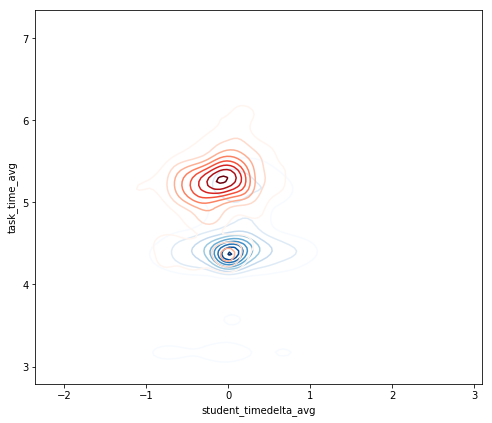

In [254]:
positives = events_train.query("label == True").sample(500)
negatives = events_train.query("label == False").sample(500)

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(
    negatives.student_timedelta_avg,
    negatives.task_time_avg,
    cmap="Blues", shade=False, shade_lowest=False)
ax = sns.kdeplot(
    positives.student_timedelta_avg,
    positives.task_time_avg,
    cmap="Reds", shade=False, shade_lowest=False)

# Add labels to the plot
# red = sns.color_palette("Reds")[-2]
# blue = sns.color_palette("Blues")[-2]
# ax.text(0.2, 0.9, "not-difficult", size=16, color=blue)
# ax.text(0.4, -0.1, "difficult", size=16, color=red)

## Comparing models

goal: compare performance of different models x different features
and explore various evaluation metrics and how much they agree with each other

todo: add evaluation metrics suitable for unbalanced problems

In [298]:
def train_model(model, features):
    X = events_train[features]
    y = events_train.label
    model.fit(X, y)
    return model

def eval_model(model, features):
    X_test = events_test[features]
    y_test = events_test.label
    class_predictions = model.predict(X_test)
    accuracy = np.mean(class_predictions == y_test)
    return {
        'accuracy': accuracy
    }    
    
models = [
    ('constant', DummyClassifier(strategy='most_frequent'),
     ['student_id']),
    ('task-avg', LogisticRegression(),
     ['task_time_avg']),
    ('student-avg', LogisticRegression(),
     ['student_timedelta_avg']),
    ('logreg', LogisticRegression(),
     ['student_timedelta_avg', 'task_time_avg']),
    ('perceptron', Perceptron(max_iter=1000, tol=0.0001),
     ['student_timedelta_avg', 'task_time_avg']),
    ('lda', LinearDiscriminantAnalysis(solver="svd"),
     ['student_timedelta_avg', 'task_time_avg']),
    ('qda', QuadraticDiscriminantAnalysis(),
     ['student_timedelta_avg', 'task_time_avg']),
]

results = {}
for name, model, features in models:
    model = train_model(model, features)
    results[name] = eval_model(model, features)
    print(name, results[name])    

constant {'accuracy': 0.95765772688849615}
task-avg {'accuracy': 0.9580163426317273}
student-avg {'accuracy': 0.95765772688849615}
logreg {'accuracy': 0.95717103409411097}
perceptron {'accuracy': 0.68208714362560519}
lda {'accuracy': 0.95783703476011173}
qda {'accuracy': 0.9579138809908041}


## Perceptron

In [181]:
# # original experiment with different features
# model = Perceptron(max_iter=1000, tol=0.0001, fit_intercept=True)
# features = ['student_solved_percentage', 'task_solved_percentage']
# train_model(model, features)
# print(eval_model(model, features))
# print('Weights:', model.coef_)
# print('Intercept:', model.intercept_)

{'accuracy': 0.94456825226055996}
Weights: [[ 0.26923077 -1.938527  ]]
Intercept: [ 0.]


Observations:
* Feature `task_solved_percentage` is 7-times more important than `student_solved_percentage`.
* The fact that the student has solved more tasks is positively correlated with the task beign labeled as too difficult. This is proably caused by the *self-selection bias*: students with more solved tasks attempt tasks at the end of the list, and these tasks are more time consuming. So this result suggests that the `student_solved_percentage` is a dangerour feauture and should not be used.

In [263]:
clf = Perceptron(max_iter=10000, tol=0.00001, fit_intercept=True)
features = ['student_timedelta_avg', 'task_time_avg']
train_model(clf, features)
print(eval_model(clf, features))
print('Weights:', clf.coef_)
print('Intercept:', clf.intercept_)

{'accuracy': 0.68208714362560519}
Weights: [[-10.25465427  20.22007572]]
Intercept: [-93.]


Text(0.5,1,'Perceptron')

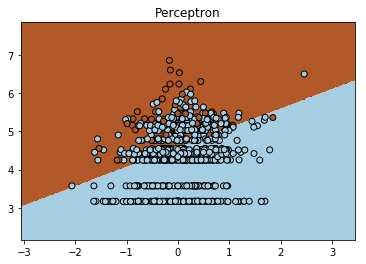

In [273]:
# Plot decision boundary
# Source: https://stats.stackexchange.com/questions/71335/decision-boundary-plot-for-a-perceptron
some_events = events_train.sample(1000)
X = some_events[features].values
y = some_events.label.values
h = 0.02
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
fig, ax = plt.subplots()
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

ax.set_title('Perceptron')

## LDA and QDA

FDA = LDA for 2 classes (?)

In [294]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
features = ['student_timedelta_avg', 'task_time_avg']
train_model(lda, features)
print(eval_model(lda, features))

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
train_model(qda, features)
print(eval_model(qda, features))

{'accuracy': 0.95783703476011173}
{'accuracy': 0.9579138809908041}


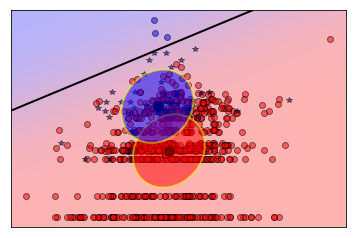

In [296]:
# plots (X and y taken from the previeous section)
# taken from scikit-learn http://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html) 

from scipy import linalg
from matplotlib import colors
import matplotlib as mpl
# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)
# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred):
    splot = plt.subplot()
    
    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    alpha = 0.5

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', alpha=alpha,
             color='red', markeredgecolor='k')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '*', alpha=alpha,
             color='#990000', markeredgecolor='k')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', alpha=alpha,
             color='blue', markeredgecolor='k')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '*', alpha=alpha,
             color='#000099', markeredgecolor='k')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10, markeredgecolor='k')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10, markeredgecolor='k')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'blue')


y_pred = lda.predict(X)
splot = plot_data(lda, X, y, y_pred)
plot_lda_cov(lda, splot)

/home/xeffenb1/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function covariances_ is deprecated; Attribute covariances_ was deprecated in version 0.19 and will be removed in 0.21. Use covariance_ instead
  warnings.warn(msg, category=DeprecationWarning)
/home/xeffenb1/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function covariances_ is deprecated; Attribute covariances_ was deprecated in version 0.19 and will be removed in 0.21. Use covariance_ instead
  warnings.warn(msg, category=DeprecationWarning)


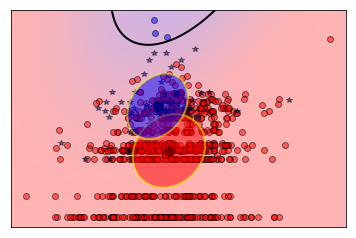

In [297]:
y_pred = qda.predict(X)
splot = plot_data(qda, X, y, y_pred)
plot_qda_cov(qda, splot)